In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

In [2]:
# 데이터 불러오기

sales = pd.read_csv('./data/sales_train.csv')
items = pd.read_csv('./data/items.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')

# 1. Preprocessing

## 1) sales data 

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
sales.shape

(2935849, 6)

In [6]:
sales.corr()   # 상관계수

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [7]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


### 날짜형식 변환

In [8]:
tc = time.time()
sales.date = pd.to_datetime(sales.date,format = '%d.%m.%Y',errors = 'raise')
time.time() - tc

0.325272798538208

In [9]:
sales.insert(1,column = 'day_of_week',value = sales.date.dt.dayofweek)
sales.insert(1,column = 'day',value = sales.date.dt.day)
sales.insert(1,column = 'month',value = sales.date.dt.month)
sales.insert(1,column = 'year',value = sales.date.dt.year)

### 중복데이터 처리

In [10]:
sales.duplicated().sum()  # sales데이터 중복행 6개

6

In [11]:
# 나머지 데이터프레임 중복값 확인
print(test.duplicated().sum())
print(items.duplicated().sum())
print(item_categories.duplicated().sum())
print(shops.duplicated().sum())

0
0
0
0


In [12]:
# sales 중복데이터 6개 삭제
sales = sales.drop_duplicates()
sales.shape  # (2935849, 6) -> (2935843, 6)

(2935843, 10)

### 결측치 처리

In [13]:
# 결측치 없음
sales.isnull().sum()

date              0
year              0
month             0
day               0
day_of_week       0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### 이상치 처리
- boxplot 활용해 이상치 확인

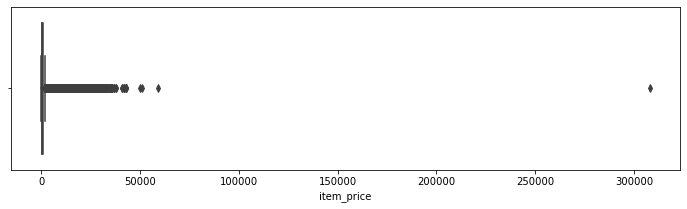

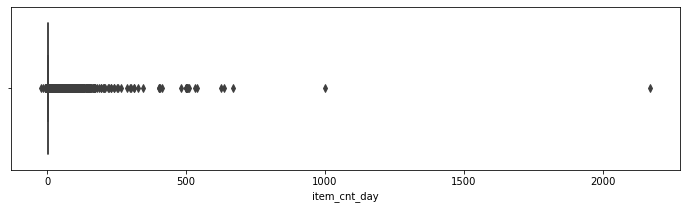

In [14]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales)
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

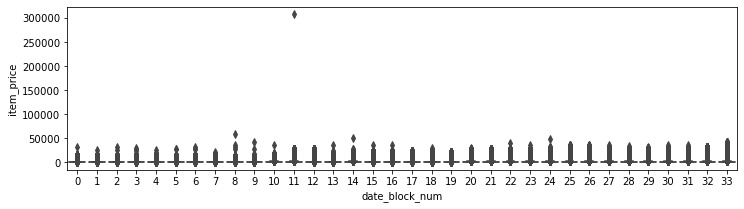

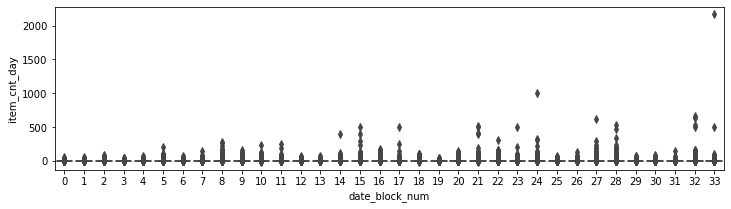

In [15]:
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_price', data = sales)
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_day', data = sales)
plt.show()

In [16]:
# 이상치 확인
# 한 아이템이 500개 초과 팔렸을때
sales[sales.item_cnt_day > 500]

,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,2014,4,22,1,15,27,8057,1200.000000,502.0
1708207,2014-06-28,2014,6,28,5,17,25,20949,5.000000,501.0
2048518,2014-10-02,2014,10,2,3,21,12,9242,1500.000000,512.0
2067669,2014-10-09,2014,10,9,3,21,55,19437,899.000000,508.0
2326930,2015-01-15,2015,1,15,3,24,12,20949,4.000000,1000.0
2608040,2015-04-14,2015,4,14,1,27,12,3731,1904.548077,624.0
2626181,2015-05-19,2015,5,19,1,28,12,11373,155.192950,539.0
2851073,2015-09-29,2015,9,29,1,32,55,9249,1500.000000,533.0
2851091,2015-09-30,2015,9,30,2,32,55,9249,1702.825746,637.0
2864235,2015-09-30,2015,9,30,2,32,12,9248,1692.526158,669.0


In [17]:
sales[sales.item_cnt_day >= 500].count()

date              14
year              14
month             14
day               14
day_of_week       14
date_block_num    14
shop_id           14
item_id           14
item_price        14
item_cnt_day      14
dtype: int64

In [18]:
sales[sales.item_price >= 50000].count()

date              3
year              3
month             3
day               3
day_of_week       3
date_block_num    3
shop_id           3
item_id           3
item_price        3
item_cnt_day      3
dtype: int64

In [19]:
# 뚜렷한 이상치를 우선 제거 -> 분석하면서 확인하기
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

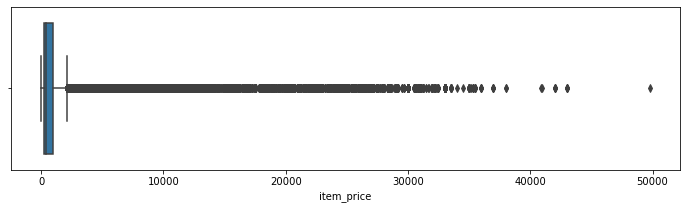

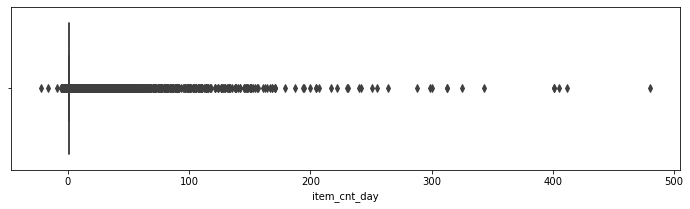

In [20]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales);
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)

plt.show()

### 특정 행 제거 
- item_price 컬럼과 item_cnt_day 컬럼의 음수값 처리하기

In [21]:
# item_price 가 0 이하인 경우
(sales.item_price <= 0).sum()

1

In [22]:
sales = sales[sales.item_price > 0] # 음수 값 처리

In [23]:
# 팔린 상품의 개수가 (-) 인 경우 -> 행 삭제?, 이전 주문과 함께 삭제
(sales['item_cnt_day'] < 0).sum()

7356

In [24]:
sales = sales[sales.item_cnt_day >= 0] # 음수 값 처리

In [25]:
train_F = sales.copy()
k = train_F[train_F.item_cnt_day < 0]
timefunc = time.time()
for i in range(len(k)):
    try:
        a = (train_F[(train_F.item_id == k.iloc[i,3]) & (train_F.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[(a.date==a.date[a.date < k.iloc[i,0]].max())].index[0]
            print(h)
            if train_F.loc[h,'item_cnt_day'] > abs(k.iloc[i,5]):
                train_F.loc[h,'item_cnt_day'] += k.iloc[i,5]
        else:
            pass
    except:
        pass
train_F.drop(train_F[train_F.item_cnt_day < 0].index, axis = 0,inplace = True)
print(time.time() - timefunc)
train_F

0.5286972522735596


,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0
5,2013-01-10,2013,1,10,3,0,25,2564,349.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,2015,10,10,5,33,25,7409,299.00,1.0
2935845,2015-10-09,2015,10,9,4,33,25,7460,299.00,1.0
2935846,2015-10-14,2015,10,14,2,33,25,7459,349.00,1.0
2935847,2015-10-22,2015,10,22,3,33,25,7440,299.00,1.0


## 2) items data 

In [26]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [27]:
# item_id와 item_category_id가 숫자로 매핑되어있어 name만 drop
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


## 3) item_categories data
- item_category_name을 라벨인코딩하여 type_id 컬럼 생성

In [28]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [29]:
type_encoder = LabelEncoder()

item_categories['split_name'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split_name'].map(lambda x: x[0].strip())
item_categories['type_id'] = type_encoder.fit_transform(item_categories['type'])

In [30]:
item_categories.head()

,item_category_name,item_category_id,split_name,type,type_id
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,1
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,1
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,1


In [31]:
item_categories['type'].value_counts()
# type으로 이상할만한 이름은 없다.

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Музыка                                6
Программы                             6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Чистые носители (штучные)             1
Чистые носители (шпиль)               1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Игры MAC                              1
Игры Android                          1
Доставка товара                       1
Билеты (Цифра)                        1
Элементы питания                      1
Name: type, dtype: int64

In [32]:
item_categories = item_categories[['item_category_id','type_id']]
item_categories.head()

,item_category_id,type_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


## 4) shops data
- shop_name컬럼의 지역명을 라벨인코딩하여 city_id 컬럼 생성

In [33]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [34]:
# shop name 확인
shops['shop_name'].value_counts()

!Якутск Орджоникидзе, 56 фран                      1
!Якутск ТЦ "Центральный" фран                      1
Москва ТЦ "Серебряный Дом"                         1
Мытищи ТРК "XL-3"                                  1
Н.Новгород ТРЦ "РИО"                               1
Н.Новгород ТРЦ "Фантастика"                        1
Новосибирск ТРЦ "Галерея Новосибирск"              1
Новосибирск ТЦ "Мега"                              1
Омск ТЦ "Мега"                                     1
РостовНаДону ТРК "Мегацентр Горизонт"              1
РостовНаДону ТРК "Мегацентр Горизонт" Островной    1
РостовНаДону ТЦ "Мега"                             1
СПб ТК "Невский Центр"                             1
СПб ТК "Сенная"                                    1
Самара ТЦ "Мелодия"                                1
Самара ТЦ "ПаркХаус"                               1
Сергиев Посад ТЦ "7Я"                              1
Сургут ТРЦ "Сити Молл"                             1
Томск ТРЦ "Изумрудный Город"                  

In [35]:
# 도시명을 공백(' ')을 기준으로 분리하기 위해 수정
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [36]:
# 공백(' ')을 기준으로 분리
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [37]:
# '!' 문자가 포함된 지명과 포함되지 않은 지명이 중복으로 표기됨. -> 통일시킴
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [38]:
shops['city'].value_counts()
# Интернет-магазин :온라인 상점?
# Выездная : 지명인지 모르겠음, 어디에도 지명이라고 안나옴
# 그래도 다른 city와 분리하기 위해 city_id로 만들어 두기로 함.

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Новосибирск          2
Н.Новгород           2
Самара               2
Красноярск           2
Казань               2
Жуковский            2
Уфа                  2
СПб                  2
Томск                1
Сургут               1
СергиевПосад         1
Химки                1
Цифровой             1
Чехов                1
Мытищи               1
Омск                 1
Адыгея               1
Курск                1
Коломна              1
Калуга               1
Интернет-магазин     1
Выездная             1
Вологда              1
Волжский             1
Балашиха             1
Ярославль            1
Name: city, dtype: int64

In [39]:
city_encoder = LabelEncoder()

shops['city_id'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_id']]
shops.head()

,shop_id,city_id
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [40]:
shops.city_id.value_counts()

13    13
29     4
18     3
4      3
24     3
16     2
15     2
20     2
11     2
8      2
6      2
25     2
19     2
23     1
22     1
21     1
26     1
27     1
28     1
14     1
17     1
0      1
12     1
10     1
9      1
7      1
5      1
3      1
2      1
1      1
30     1
Name: city_id, dtype: int64

## 5) test data

In [41]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [42]:
test.shape

(214200, 3)

In [43]:
# test 데이터에서 shop_id는 42개
len(test.shop_id.unique())

42

In [44]:
# test 데이터에는 있지만 sales 데이터에는 없는 item_id가 총 363개 있다.
# 363개의 item_id에 대한 판매량은 0으로 예측
len(set(test.item_id) - set(sales.item_id))

363

In [45]:
test['date_block_num'] = 34

In [46]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


## 6) submission data

In [47]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 7) 데이터 merge 

### revenue 컬럼 생성

In [48]:
sales.head()

,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0
5,2013-01-10,2013,1,10,3,0,25,2564,349.00,1.0


In [49]:
# 총 수익
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.head()

,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,999.00
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,899.00
3,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,2013,1,10,3,0,25,2564,349.00,1.0,349.00


### matrix 데이터프레임 생성 및 컬럼추가
- 월별(date_block_num), 상점별(shop_id), 아이템별(item_id)
- city_id, item_category_id, type_id 컬럼추가(merge)

In [50]:
ts = time.time() # 코드 시작 시간
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id'] # 월별, 상점별, 아이템별

for i in range(34):
    sales_df = sales[sales.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], 
                    sales_df.shop_id.unique(), sales_df.item_id.unique())),
                    dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols, inplace=True)
time.time()-ts # 코드 실행 시간

# itertools.product : 중복 순열
# 월별, 상점별, 아이템별로 모든 가능한 조합을 나타낸다.
# vstack : 이 조합들을 월 순서대로 행 아래에 더해준다.

10.211114168167114

In [51]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [55]:
matrix = pd.concat([matrix, test], ignore_index = True, sort=False, keys=cols)
matrix.fillna(0, inplace = True)
matrix

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id,ID
0,0,0,19,29.0,40.0,11.0,0.0
1,0,0,27,29.0,19.0,5.0,0.0
2,0,0,28,29.0,30.0,8.0,0.0
3,0,0,29,29.0,23.0,5.0,0.0
4,0,0,32,29.0,40.0,11.0,0.0
...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,0.0,0.0,214195.0
11098656,34,45,16188,0.0,0.0,0.0,214196.0
11098657,34,45,15757,0.0,0.0,0.0,214197.0
11098658,34,45,19648,0.0,0.0,0.0,214198.0


In [56]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11098660 entries, 0 to 11098659
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   city_id           float64
 4   item_category_id  float64
 5   type_id           float64
 6   ID                float64
dtypes: float64(4), int64(3)
memory usage: 592.7 MB


In [57]:
matrix['ID'] = matrix['ID'].astype(np.int32)

In [58]:
matrix.head()

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id,ID
0,0,0,19,29.0,40.0,11.0,0
1,0,0,27,29.0,19.0,5.0,0
2,0,0,28,29.0,30.0,8.0,0
3,0,0,29,29.0,23.0,5.0,0
4,0,0,32,29.0,40.0,11.0,0


In [59]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left') # 'city_id' 추가 됨
matrix= pd.merge(matrix, items, on=['item_id'], how='left')
matrix= pd.merge(matrix, item_categories, on=['item_category_id'], how='left') # 'item_category_id', 'type_id' 추가 됨
matrix['city_id'] = matrix['city_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_id'] = matrix['type_id'].astype(np.int8)

# 결과적으로 위의 matrix1 데이터에 3개 컬럼 추가

KeyError: 'item_category_id'

In [60]:
matrix.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y
0,0,0,19,29.0,40.0,11.0,0,29,40
1,0,0,27,29.0,19.0,5.0,0,29,19
2,0,0,28,29.0,30.0,8.0,0,29,30
3,0,0,29,29.0,23.0,5.0,0,29,23
4,0,0,32,29.0,40.0,11.0,0,29,40


In [61]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)

In [62]:
matrix

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y
0,0,0,19,29.0,40.0,11.0,0,29,40
1,0,0,27,29.0,19.0,5.0,0,29,19
2,0,0,28,29.0,30.0,8.0,0,29,30
3,0,0,29,29.0,23.0,5.0,0,29,23
4,0,0,32,29.0,40.0,11.0,0,29,40
...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,0.0,0.0,214195,20,55
11098656,34,45,16188,0.0,0.0,0.0,214196,20,64
11098657,34,45,15757,0.0,0.0,0.0,214197,20,55
11098658,34,45,19648,0.0,0.0,0.0,214198,20,40


- 월별 매출액(item_cnt_day)데이터 생성 및 matrix 데이터프레임에 merge

In [63]:
# 월별 매출액
# 월별, 상점별, 아이템별을 그룹화 하고, 일별 판매 개수('item_cnt_day')를 더해줌
group = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [64]:
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [65]:
# matrix 에 gorup데이터 merge 하여 컬럼을 붙임('item_cnt_month')
matrix = pd.merge(matrix, group, how='left')
matrix.head()
# NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리??

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month
0,0,0,19,29.0,40.0,11.0,0,29,40,NaN
1,0,0,27,29.0,19.0,5.0,0,29,19,NaN
2,0,0,28,29.0,30.0,8.0,0,29,30,NaN
3,0,0,29,29.0,23.0,5.0,0,29,23,NaN
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0


In [66]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098660 entries, 0 to 11098659
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_block_num      int8   
 1   shop_id             int8   
 2   item_id             int64  
 3   city_id_x           float64
 4   item_category_id_x  float64
 5   type_id             float64
 6   ID                  int32  
 7   city_id_y           int32  
 8   item_category_id_y  int64  
 9   item_cnt_month      float64
dtypes: float64(4), int32(2), int64(2), int8(2)
memory usage: 698.6 MB


In [67]:
# 결측값을 어떻게 처리 할 지 생각해보기!!!
# 일단 0으로 처리
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0


- decjan 컬럼 생성 및 matrix 데이터프레임에 merge
  - 판매량이 많은 연말과 연초 (12월, 1월) -> 1 / 나머지는 0으로 변환

In [68]:
# 월 별 총 판매개수
group1 = sales.groupby(by=['date_block_num']).sum()
group1 = group1.reset_index()
group1.head()

,date_block_num,year,month,day,day_of_week,shop_id,item_id,item_price,item_cnt_day,revenue
0,0,232173381,115337,1683744,377229,3405258,1180625892,8.179800e+07,131849.0,9.239894e+07
1,1,218060238,216652,1603822,381905,3102452,1073485127,7.528300e+07,128382.0,9.096449e+07
2,2,243679689,363159,1908229,441427,4006652,1218233402,8.396688e+07,147438.0,1.052654e+08
3,3,188950245,375460,1477952,313094,3157303,969139844,6.121918e+07,107439.0,6.945713e+07
4,4,184352553,457905,1449428,301141,3087675,948704341,5.708693e+07,107147.0,6.525317e+07


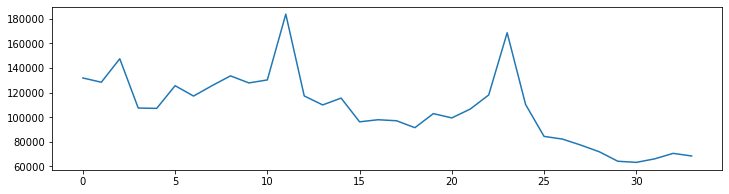

In [69]:
plt.figure(figsize=(12,3))
plt.plot(group1.date_block_num,  group1.item_cnt_day)
plt.show()

In [70]:
# 연말(12월), 연초(1월)에 판매량이 많은 것으로 확인
# 12월,1월 -> 1 / 나머지 -> 0 으로 변환하여 decjan 컬럼생성

In [71]:
matrix['decjan'] = np.where(matrix['date_block_num'].isin([11,12,23,24]), 1,0)
matrix.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0


In [72]:
# decjan 확인하기
print(len(matrix.loc[matrix['date_block_num'] == 11,:]))
print(len(matrix.loc[matrix['date_block_num'] == 12,:]))
print(len(matrix.loc[matrix['date_block_num'] == 23,:]))
print(len(matrix.loc[matrix['date_block_num'] == 24,:]))

389712
347116
330000
306800


In [73]:
389712+347116+330000+306800

1373628

In [74]:
(matrix['decjan'] == 1).sum()  # 1373628

# 합이 동일하므로 올바르게 변환됨을 확인

1373628

- shop_cnt_month (shop별 월 총 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [75]:
# 월별 shop별 평균 판매 수량(shop_cnt_month) 
group2 = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['shop_cnt_month']
group2.reset_index(inplace=True)

In [76]:
group2.head()

,date_block_num,shop_id,shop_cnt_month
0,0,0,5576.0
1,0,1,2948.0
2,0,2,1151.0
3,0,3,767.0
4,0,4,2116.0


In [77]:
matrix = pd.merge(matrix, group2, on=['date_block_num', 'shop_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan,shop_cnt_month
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0,5576.0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0,5576.0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0,5576.0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0,5576.0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0,5576.0


In [78]:
# matrix 원본 카피
matrix1 = matrix.copy()
matrix1.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan,shop_cnt_month
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0,5576.0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0,5576.0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0,5576.0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0,5576.0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0,5576.0


In [79]:
## matrix에 월별 categoty별 판매된 제품의 수(categoty_cnt_month) 
group2 = matrix1.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['category_cnt_month']
group2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group2, on=['date_block_num', 'item_category_id'], how='left')
matrix1.head()

KeyError: 'item_category_id'

In [ ]:
# date_block_num, city 별 판매된 제품의 수
group_1 = matrix1.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['sum']})
group_1.columns = ['city_cnt_month']
group_1.reset_index(inplace=True)




matrix1 = pd.merge(matrix1, group_1, on=['date_block_num', 'city_id'], how='left')
matrix1.head()

In [ ]:
# date_block_num, city 별 판매된 제품의 수
group_1 = matrix1.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['sum']})
group_1.columns = ['city_cnt_month']
group_1.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_1, on=['date_block_num', 'city_id'], how='left')
matrix1.head()

In [ ]:
#type_cnt_month : date_block_num, type별 판매된 제품 수
types = matrix1.groupby(['date_block_num', 'type_id']).agg({'item_cnt_month' : 'sum'})
types.columns = ['type_cnt_month']
types.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, types, on = ['date_block_num', 'type_id'], how = 'left')
matrix1.head()

In [ ]:
# shop, item별 가격
group_2 = sales.groupby(['shop_id', 'item_id']).agg({'item_price': ['mean']})
group_2.columns = ['item_price_by_id'] # item_price_by_shop
group_2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_2, on = ['shop_id', 'item_id'], how = 'left')
matrix1.head()

In [ ]:
# date_block_num, shop, item 별 판매된 제품의 수
z = sales[['date','date_block_num','shop_id','item_id','item_cnt_day']]
k = z.groupby(by = ['date_block_num','shop_id','item_id']).sum()
k['item_shop_cnt_month'] = k.item_cnt_day
k.drop('item_cnt_day',axis = 1,inplace = True)
matrix1 = matrix1.merge(k,left_on = ['date_block_num','shop_id','item_id'],right_on = ['date_block_num','shop_id','item_id'])
matrix1.head()

In [80]:
matrix1.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan,shop_cnt_month
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0,5576.0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0,5576.0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0,5576.0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0,5576.0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0,5576.0


In [81]:
# 2014년 2월 28일 이전 이후
sales.loc[sales.date > datetime.strptime('2014-02-28','%Y-%m-%d'),'aft0228'] = 1

In [82]:
matrix2 = matrix1.copy()

In [83]:
# decjan 원-핫 인코딩
pd.get_dummies(matrix2, columns = ['decjan'])

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,shop_cnt_month,decjan_0,decjan_1
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,5576.0,1,0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,5576.0,1,0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,5576.0,1,0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,5576.0,1,0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,5576.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,0.0,0.0,214195,20,55,0.0,0.0,1,0
11098656,34,45,16188,0.0,0.0,0.0,214196,20,64,0.0,0.0,1,0
11098657,34,45,15757,0.0,0.0,0.0,214197,20,55,0.0,0.0,1,0
11098658,34,45,19648,0.0,0.0,0.0,214198,20,40,0.0,0.0,1,0


In [84]:
# decjan 평균값 인코딩
decjan_mean = matrix2.groupby('decjan')['item_cnt_month'].mean()
matrix2['decjan_mean'] = matrix2['decjan'].map(decjan_mean)

In [85]:
matrix2.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan,shop_cnt_month,decjan_mean
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0,5576.0,0.315186
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0,5576.0,0.315186
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0,5576.0,0.315186
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0,5576.0,0.315186
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0,5576.0,0.315186


In [91]:
#12,1월 인코딩 했을 때 비율
decjan_mean

decjan
0    2.216797
1    2.570312
Name: item_cnt_month, dtype: float16

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098660 entries, 0 to 11098659
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_block_num      int8   
 1   shop_id             int8   
 2   item_id             int64  
 3   city_id_x           float64
 4   item_category_id_x  float64
 5   type_id             float64
 6   ID                  int32  
 7   city_id_y           int32  
 8   item_category_id_y  int64  
 9   item_cnt_month      float16
 10  decjan              int32  
 11  shop_cnt_month      float16
 12  decjan_mean         float16
dtypes: float16(3), float64(3), int32(3), int64(2), int8(2)
memory usage: 719.7 MB


In [88]:
#matrix2 = matrix1.copy()

In [89]:
#group_2 = sales.groupby(['item_id']).agg({'item_price': ['mean']})
#group_2.columns = ['item_price_by_id']
#group_2.reset_index(inplace=True)
#matrix2 = pd.merge(matrix2, group_2, on = ['item_id'], how = 'left')
#matrix2.head()

In [90]:
#sales[sales['item_id'] == 11]

In [91]:
#matrix2.item_price_by_id_x.isnull().sum()

In [92]:
#matrix2.item_price_by_id_y.isnull().sum()

### 첫번째 판매 후 지난 개월수 데이터 생성 및 matrix에 merge
- item_shop_fisrst_sale, item_first_sale 

In [93]:
# 마지막 판매가 있고 나서부터 지난 개월 수 -> 추세 파악을 위해 먼저 이 코드 실행
# shop-item 별

cache = {}
matrix1['item_shop_last_sale'] = -1
matrix1['item_shop_last_sale'] = matrix1['item_shop_last_sale'].astype(np.int8)

for index, row in matrix1.iterrows():
    key = str(row.item_id) + ' ' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix1.at[index, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
# 20분 걸림

KeyboardInterrupt: 

In [ ]:
# item별
cache = {}
matrix1['item_last_sale'] = -1
matrix1['item_last_sale'] = matrix1['item_last_sale'].astype(np.int8)

for index, row in matrix1.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix1.at[index, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

# 15분 걸림

In [94]:
#첫번째 판매 후 지난 개월 수 (shop-item pair, item pair 별)

matrix1.groupby(['item_id','shop_id'])['date_block_num']
matrix1['date_block_num'] - matrix1.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

0            0
1            0
2            0
3            0
4            0
            ..
11098655    11
11098656     2
11098657    34
11098658    11
11098659    17
Name: date_block_num, Length: 11098660, dtype: int8

In [95]:
matrix1['item_shop_first_sale'] = matrix1['date_block_num'] - matrix1.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
matrix1['item_first_sale'] = matrix1['date_block_num'] - matrix1.groupby('item_id')['date_block_num'].transform('min')
matrix1.head()

,date_block_num,shop_id,item_id,city_id_x,item_category_id_x,type_id,ID,city_id_y,item_category_id_y,item_cnt_month,decjan,shop_cnt_month,item_shop_last_sale,item_shop_first_sale,item_first_sale
0,0,0,19,29.0,40.0,11.0,0,29,40,0.0,0,5576.0,-1,0,0
1,0,0,27,29.0,19.0,5.0,0,29,19,0.0,0,5576.0,-1,0,0
2,0,0,28,29.0,30.0,8.0,0,29,30,0.0,0,5576.0,-1,0,0
3,0,0,29,29.0,23.0,5.0,0,29,23,0.0,0,5576.0,-1,0,0
4,0,0,32,29.0,40.0,11.0,0,29,40,6.0,0,5576.0,-1,0,0


In [96]:
matrix1.info()

1608221
2928469

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098660 entries, 0 to 11098659
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int8   
 1   shop_id               int8   
 2   item_id               int64  
 3   city_id_x             float64
 4   item_category_id_x    float64
 5   type_id               float64
 6   ID                    int32  
 7   city_id_y             int32  
 8   item_category_id_y    int64  
 9   item_cnt_month        float16
 10  decjan                int32  
 11  shop_cnt_month        float16
 12  item_shop_last_sale   int8   
 13  item_shop_first_sale  int8   
 14  item_first_sale       int8   
dtypes: float16(2), float64(3), int32(3), int64(2), int8(5)
memory usage: 730.3 MB


2928469

In [97]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928469 entries, 0 to 2935848
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   year            int64         
 2   month           int64         
 3   day             int64         
 4   day_of_week     int64         
 5   date_block_num  int64         
 6   shop_id         int64         
 7   item_id         int64         
 8   item_price      float64       
 9   item_cnt_day    float64       
 10  revenue         float64       
 11  aft0228         float64       
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 355.0 MB


# 2. EDA

### 1) 월별 거래수

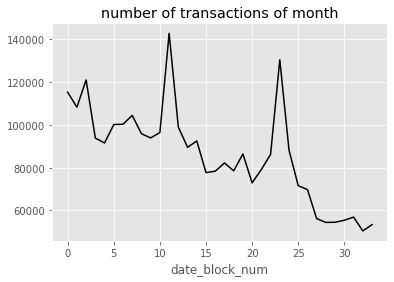

In [98]:
#월별 거래수
sales.groupby('date_block_num').count()
sales.groupby('date_block_num')['date'].count()

transactions = sales.groupby('date_block_num')['date'].count()
transactions

plt.style.use('ggplot')
transactions.plot(title = 'number of transactions of month', color = 'black')
plt.show()

전체적으로 월별 거래수가 꾸준히 하락함  
엄청 높게 치솟는 두 개 점은 연말(13년 12월, 14년 12월)임

### 2) 월별 거래된 shops 수, 월별 거래된 items 수

In [101]:
# 각 월 블록에서 매출 데이터에 거래가 있는 고유 상점 및 품목 수
shop_count = sales.groupby('date_block_num')['shop_id'].nunique()
item_count = sales.groupby('date_block_num')['item_id'].nunique()

sales.groupby('date_block_num').nunique()
#sales.groupby('date_block_num')['shop_id'].nunique() # 월별 고유 상점수
#sales.groupby('date_block_num')['item_id'].nunique()  # 월별 고유 아이템수

sales['item_id'].nunique() #item 21802개
items['item_id'].nunique() #item 22170개
#sales['shop_id'].nunique() #shop 60개
shops['shop_id'].nunique() #shop 60개

60

sales에 있는 item_id랑 items에 있는 item_id의 수가 다름

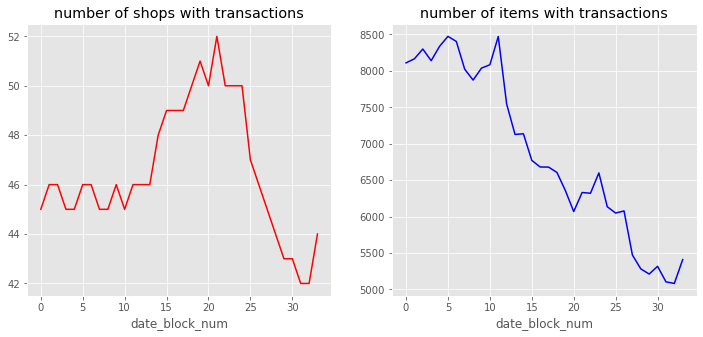

In [102]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
shop_count.plot(ax = ax[0], color = 'red')
item_count.plot(ax = ax[1], color = 'blue')
ax[0].set_title('number of shops with transactions') #거래가 있는 상점수
ax[1].set_title('number of items with transactions') #거래된 아이템수
plt.show()

연말을 제외하고는 월별 거래수와 월별 거래된 아이템수 모두 하락세
거래처들의 수는 2년차부터는 느는 듯 했으나 2말부터 훅훅 떨어짐  
그리고 거래처수가 60개로 나오는데 차트를 보면 매달 모든 가게에서 거래되는 게 아니고 물건도 많이 못미침

### 3) 상점별 하루 item 판매개수

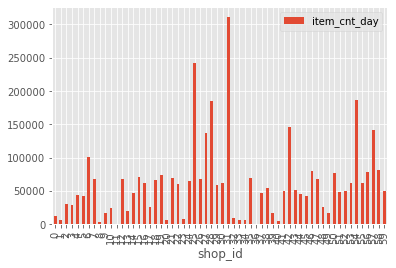

In [103]:
shop_ns = sales[['shop_id','item_cnt_day']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.show()

### 4) 가격별 item 하루 판매개수

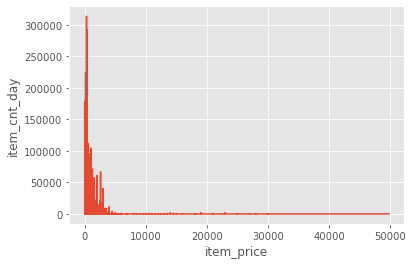

In [104]:
price_ns = sales[['item_price','item_cnt_day']]
price_ns = price_ns.groupby(by=['item_price']).sum()
plt.plot(price_ns.index, price_ns.values)
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.show()

### 5) 월별 총 판매금액

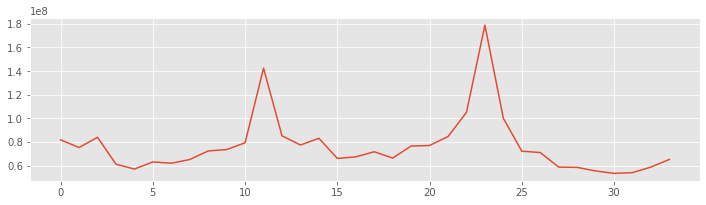

In [105]:
# 월별 총 판매금액
time_ns = sales[['item_price','date_block_num']]
time_ns = time_ns.groupby(by=['date_block_num']).sum()
plt.figure(figsize=(12,3))
plt.plot(time_ns.index, time_ns.values)
plt.show()

### 6) 월별 총 판매개수

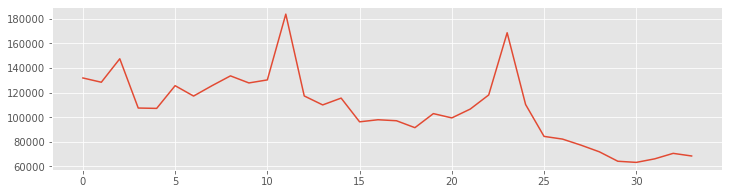

In [106]:
# 월별 총 판매개수
group1 = sales.groupby(by=['date_block_num']).sum()
group1 = group1.reset_index()
plt.figure(figsize=(12,3))
plt.plot(group1.date_block_num,  group1.item_cnt_day)
plt.show()

### 7) 품목별 판매량

In [107]:
sales1= pd.merge(sales, items, on=['item_id'], how='left')
sales1= pd.merge(sales1, item_categories, on=['item_category_id'], how='left')
sales1.head()

,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,aft0228,item_category_id,type_id
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,999.00,NaN,37,11
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,899.00,NaN,58,13
2,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,1709.05,NaN,58,13
3,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,1099.00,NaN,56,13
4,2013-01-10,2013,1,10,3,0,25,2564,349.00,1.0,349.00,NaN,59,13


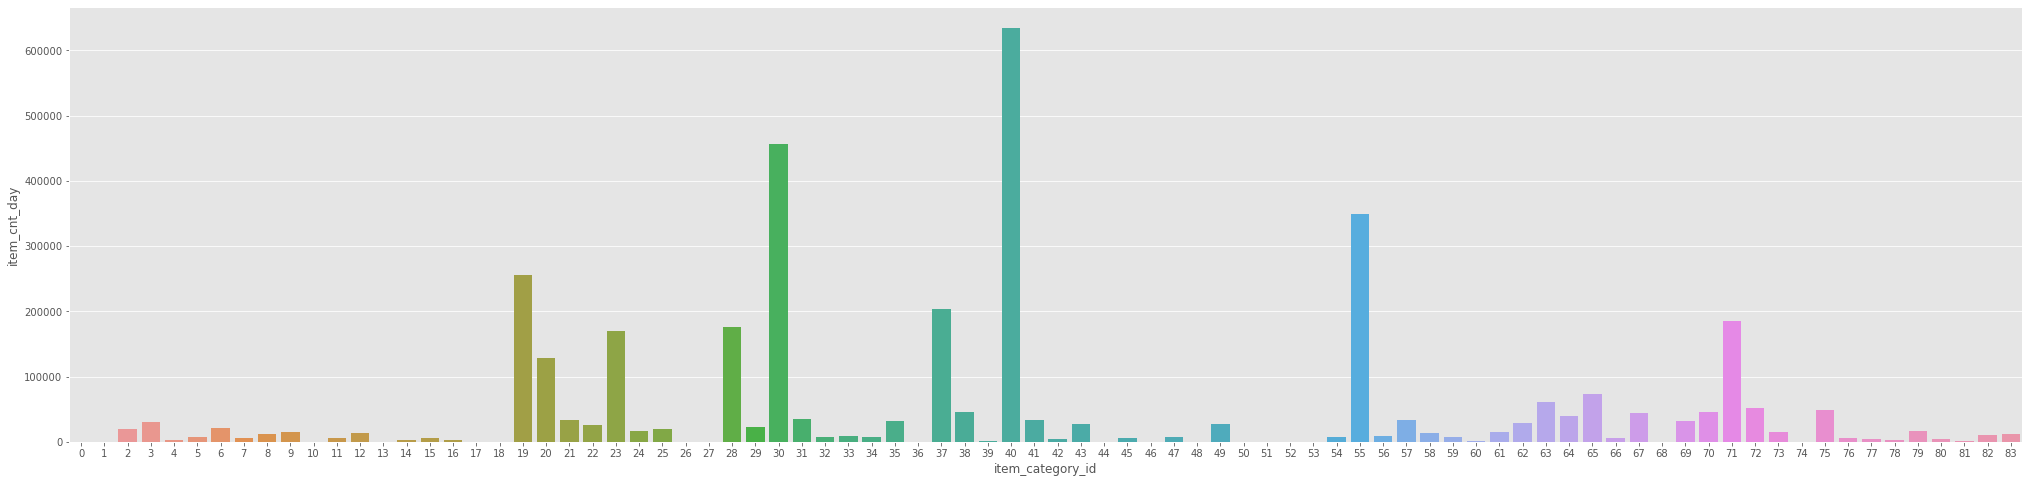

In [108]:
# 품목별 판매량 
Category_sum=sales1.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="item_cnt_day", data=Category_sum)
plt.show()

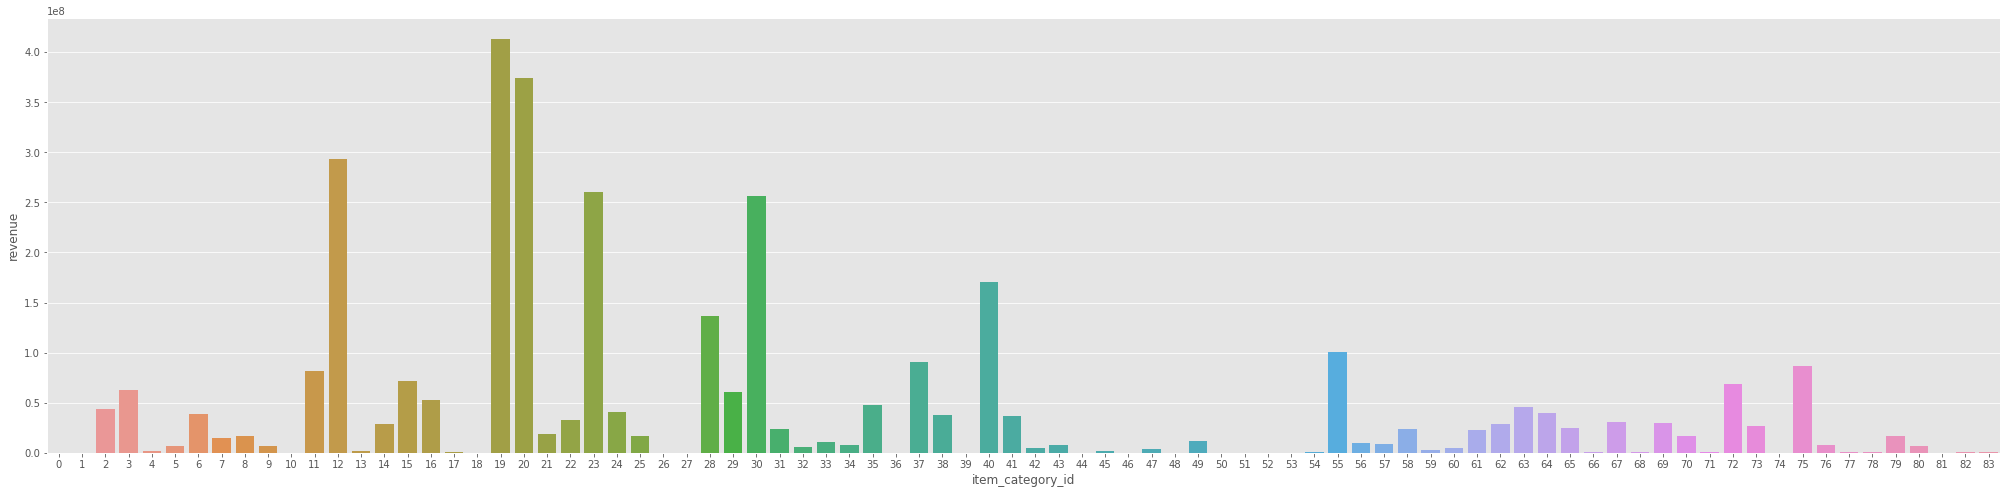

In [109]:
# 카테고리별 판매금액
Category_sum=sales1.groupby(['item_category_id'], as_index=False)['revenue'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="revenue", data=Category_sum)
plt.show()

In [110]:
sales1['year'] = sales1['date'].dt.year
sales1['month'] = sales1['date'].dt.month
sales1.head()

,date,year,month,day,day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,aft0228,item_category_id,type_id
0,2013-01-02,2013,1,2,2,0,59,22154,999.00,1.0,999.00,NaN,37,11
1,2013-01-03,2013,1,3,3,0,25,2552,899.00,1.0,899.00,NaN,58,13
2,2013-01-06,2013,1,6,6,0,25,2554,1709.05,1.0,1709.05,NaN,58,13
3,2013-01-15,2013,1,15,1,0,25,2555,1099.00,1.0,1099.00,NaN,56,13
4,2013-01-10,2013,1,10,3,0,25,2564,349.00,1.0,349.00,NaN,59,13


KeyboardInterrupt: 

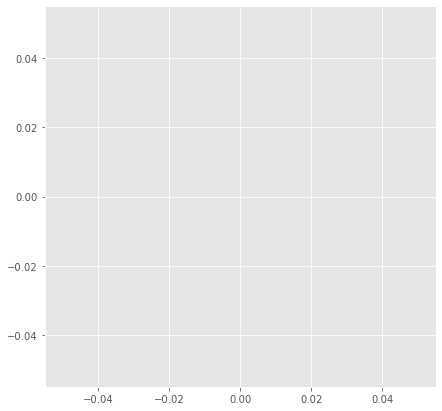

In [111]:
#연도별 판매량  -> Year, Month 컬럼 만든 후 확인 가능합니다(이재호)
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['year'],y=sales1['item_cnt_day'])
plt.show()

In [ ]:
# 월별 판매량
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['month'],y=sales1['item_cnt_day'])
plt.show()

In [ ]:
# 연도별 판매총액 >> 14년 까진 꾸준하다가 14년부터 판매량 감소
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales1['year'],y=sales1['revenue'])
plt.show()

In [ ]:
# 상점별 월 item 판매개수 -> 월 별 item 판매개수 컬럼 만든 후 확인 가능합니다.(김홍비)
shop_ns = matrix[['shop_id','item_cnt_month']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.xlabel('shop_id')
plt.ylabel('item_cnt_month')
plt.show()

In [ ]:
# 카테고리별 판매개수
category_ns = matrix[['item_category_id','item_cnt_month']]
category_ns.set_index(['item_category_id'])
category_ns = category_ns.groupby(by=['item_category_id']).sum()
category_ns.plot(kind = 'bar')
plt.xlabel('category_id')
plt.ylabel('item_cnt_month')
plt.show()

In [ ]:
# 도시별 판매개수
city_ns = matrix[['city_id','item_cnt_month']]
city_ns.set_index(['city_id'])
city_ns = city_ns.groupby(by=['city_id']).sum()
city_ns.plot(kind = 'bar')
plt.xlabel('city_id')
plt.ylabel('item_cnt_month')
plt.show()

In [ ]:
# 동일한 item의 shop별 가격차이
sales_temp = sales[sales['shop_id'] == 31][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 31',fontsize="28")
axes.legend()
plt.show()


sales_temp = sales[sales['shop_id'] == 28][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 28',fontsize="28")
axes.legend()
plt.show()


sales_temp = sales[sales['shop_id'] == 21][['date','item_id','item_price']].reset_index(drop=True)
items_list = sales_temp['item_id'].unique()[0:8]

fig, axes = plt.subplots(1,1, figsize=(25,8))
colors = ['red','orange','blue','green','yellow','purple','cyan','brown']
for i, item in enumerate(items_list):
    dprice = sales_temp[sales_temp['item_id'] == item][['item_price','date']]
    
    sns.lineplot(x=dprice['date'], y=dprice['item_price'], ax=axes, color=colors[i], label=item)
    
axes.set_title('Price development of items - shop_id 21',fontsize="28")
axes.legend()
plt.show()

### [ 환불 적용 모듈 ]

In [ ]:
train_F = sales.copy()
k = train_F[train_F.item_cnt_day < 0]
qwe = 0
minimum = 0
timefunc = time.time()
for i in range(len(k)):
    try:
        if k.iloc[i,5] < minimum:
            minimum = k.iloc[i,5]
        a = (train_F[np.array(train_F.item_id == k.iloc[i,3]) & np.array(train_F.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[a.date==a.date[a.date < k.iloc[i,0]].max()].index[0]
            qwe += 1
            train_F.loc[h,'item_cnt_day'] += k.iloc[i,5]
#            if qwe == 5:
#                break
        else:
            pass
    except:
        pass
train_F.drop(k.index,axis = 0,inplace = True)
print(len(k))
print('필요 없는 값:',(len(k) - qwe))
print('적용한 값의 수::',qwe)
print(minimum)
print(time.time() - timefunc)